# Dataset Preparation

First upload the **dataset.zip** file and unzip dataset

In [ ]:
!unzip dataset.zip

Load and Preprocess Data

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms import functional as F

# --- Augmentation transforms ---
rotate = transforms.RandomRotation(degrees=15, fill=255)
translate = transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=255)
to_tensor = transforms.ToTensor()
blur = transforms.GaussianBlur(kernel_size=3)
# random_erase = transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=255)

# --- Composed transforms ---
t_rotate = transforms.Compose([rotate, to_tensor])
t_translate = transforms.Compose([translate, to_tensor])
t_rotate_translate = transforms.Compose([rotate, translate, to_tensor])
t_blur = transforms.Compose([blur, to_tensor])
t_blur_rotate = transforms.Compose([blur, rotate, to_tensor])
t_blur_translate = transforms.Compose([blur, translate, to_tensor])
t_blur_rotate_translate = transforms.Compose([blur, rotate, translate, to_tensor])

# --- Crop definitions ---
crops = [
    (0, 0, 200, 200),     # no crop
    (25, 25, 175, 175),   # small crop
    (50, 38, 163, 163),   # medium crop
    (75, 38, 163, 163)    # big crop
]

# --- Setup containers ---
gtlabels = {}
dataset = {}

# --- Resize target ---
resize_to = transforms.Resize((100, 100))

# --- Load dataset and augment ---
for i, folder in enumerate(os.listdir("dataset")):
    gtlabels[i] = folder
    dataset[i] = []
    folder_path = os.path.join("dataset", folder)

    for file in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, file)).convert('L')

        for crop_box in crops:
            # Crop
            cropped = img.crop(crop_box)

            # Resize to 100x100
            cropped = resize_to(cropped)

            # Convert to tensor and store
            dataset[i].append(to_tensor(cropped))

            # Convert to PIL for augmentations
            pil_img = cropped

            # Apply augmentations
            dataset[i].append(t_rotate(pil_img))
            dataset[i].append(t_translate(pil_img))
            dataset[i].append(t_rotate_translate(pil_img))
            dataset[i].append(t_blur(pil_img))
            dataset[i].append(t_blur_rotate(pil_img))
            dataset[i].append(t_blur_translate(pil_img))
            dataset[i].append(t_blur_rotate_translate(pil_img))


Create Full Dataset

In [ ]:
full_dataset = [(img, label) for label in dataset.keys() for img in dataset[label]]

Split Dataset

In [ ]:
from torch.utils.data import Dataset, random_split

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size # Ensure all samples are used

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42) # For reproducibility
)

Create Data Loaders

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Check Dataset Sizes

In [ ]:
print(len(train_loader)*batch_size)
print(len(val_loader)*batch_size)
print(len(test_loader)*batch_size)

2528
544
544


# Model Definition and Training

Set Device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Define Model Architecture

In [ ]:
from torch import nn

f = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Dropout(0.25),
    nn.Flatten(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 14)
).to(device)

Determine Linear Layer Input Size

In [ ]:
# this code is for find input for first fully connected Linear layer

x = torch.randn(1, 1, 100, 100).to(device)  # (batch, channel, height, width)
out = f[:10](x)  # pass through conv layers up to Flatten
print(out.shape)


torch.Size([1, 128, 1, 1])


Initialize Lists for Metrics

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

Set Number of Epochs

In [ ]:
epochs = 200

Train Model

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(f.parameters(), lr=1e-3)

prbar = tqdm(range(epochs))
for epoch in prbar:
  running_loss = 0.0
  correct = 0
  total = 0
  f.train()
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    output = f(images)
    loss = ce(output, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # accumulate loss
    running_loss += loss.item() * images.size(0)

    # compute accuracy
    _, predicted = torch.max(output.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  with torch.no_grad():
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    f.eval()
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val_output = f(images)
      val_loss = ce(val_output, labels)
      # val_loss.append(loss.item())

      # accumulate loss
      val_running_loss += val_loss.item() * images.size(0)

      # compute accuracy
      _, predicted = torch.max(val_output.data, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()


  train_losses.append(running_loss / total)
  train_acc.append(100 * correct / total)
  val_losses.append(val_running_loss / val_total)
  val_acc.append(100 * val_correct / val_total)

  prbar.set_description_str(f"Loss {train_losses[-1]:.4f}")



# Results and Evaluation

Plot Loss

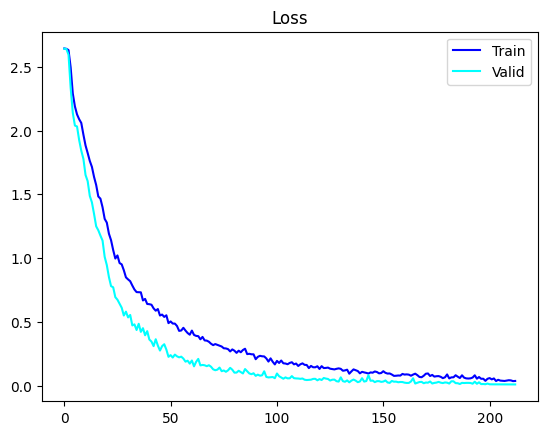

In [ ]:
from matplotlib import pyplot as plt

plt.title("Loss")
plt.plot(train_losses, label="Train", color="blue")
plt.plot(val_losses, label="Valid", color="aqua")
plt.legend()
plt.show()

Plot Accuracy

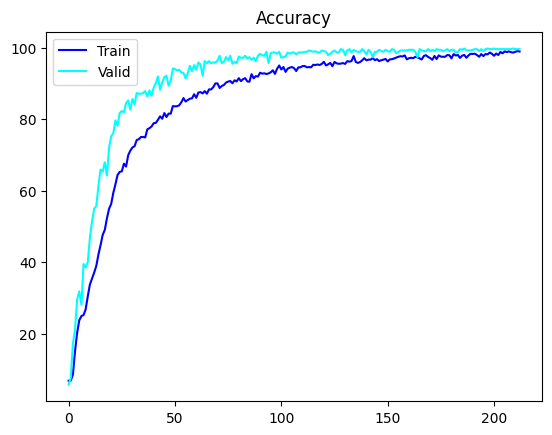

In [ ]:
plt.title("Accuracy")
plt.plot(train_acc, label="Train", color="blue")
plt.plot(val_acc, label="Valid", color="aqua")
plt.legend()
plt.show()

Evaluate on Test Set

In [ ]:
f.eval()  # set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = f(images)
        loss = ce(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / total
test_accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.0329, Test Accuracy: 98.70%


Save Model

In [ ]:
torch.save(f.state_dict(), f"modelT{int(test_accuracy)}.pth")